# 28th of June, 2018
## Benjamin Adam Catching
## Andino Lab Rotation
## Poliovirus DIP Project

**Paper**: Highly Parallel Genome-wide Expression Profiling of Individual Cells Using Nanoliter Droplets  
_Cell_, McCarroll Lab, (2015)  
* 
## Paper will be read after image analysis

## Analyze bulk droplets
Each 8-bit image, both 4X and 10X, has two channels; brightfield and GFP. The GFP channel reports either the TIP or WT virus, so cells need to be determined from brightfield. This may not be necessary in the future if DAPI or cytosol markers are introduced to the HeLa cells, but for now cells will be segmented from brightfield. The goal is to collect the number of cells per droplet and from those cell determine the ones that are alive or dead and infected or not.

### Defined Droplets
As the outline of the droplets are dark, threshold the image above the intensity of the outlines. From the black white images, fill if necessary (as cells show up dark) to create a droplet region. Since inter-droplet space will also be picked up, the regions need to be filtered for ellipicity (should be low). Filtered regions will should include all droplets.  

### Determine Cells in Droplets
Cells are determined from brightfield, so values in that region lower than the Otsu threshold should encompass cells. Again filling the thresholded image should create a cell black-white mask. From the mask individual cells can be segmented through the method developed yesterday. 

### Determine if Cell is Alive and/or Infected
The segmented cells should have a certain size, a radius around 10 $\mu$m. If the size is significantly above or below this size the cell should be counted as dead. If the cell ellipticity is above 0.5, the cell is probably dead and should be counted as dead. From this sorting of dead and alive, the black-white mask of the alive cells can be applied to the GFP channel to determine the amount of fluorescence. If the fluorescence is below a certain threshold (otsu), count as uninfected. If the fluorescence is above, log it as certain level.

In [2]:
# Import packages

# Data modification
import glob
import numpy as np

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle


import skimage.filters
import skimage.io
import skimage.morphology
import skimage.exposure
import skimage.color
import skimage.segmentation

sns.set(style='dark', palette=sns.color_palette(), rc={'axes.labelsize': 20}, font_scale=2)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [8]:
# Define the location of the image files
bulk_bright = "../data/06.27_HeLa-poliovirus/#1/4x_TRANS.tif"
bulk_gfp = "../data/06.27_HeLa-poliovirus/#1/4x_GFP.tif"

In [9]:
# Read in the images
image_bright = skimage.io.imread(bulk_bright)
image_gfp = skimage.io.imread(bulk_gfp)

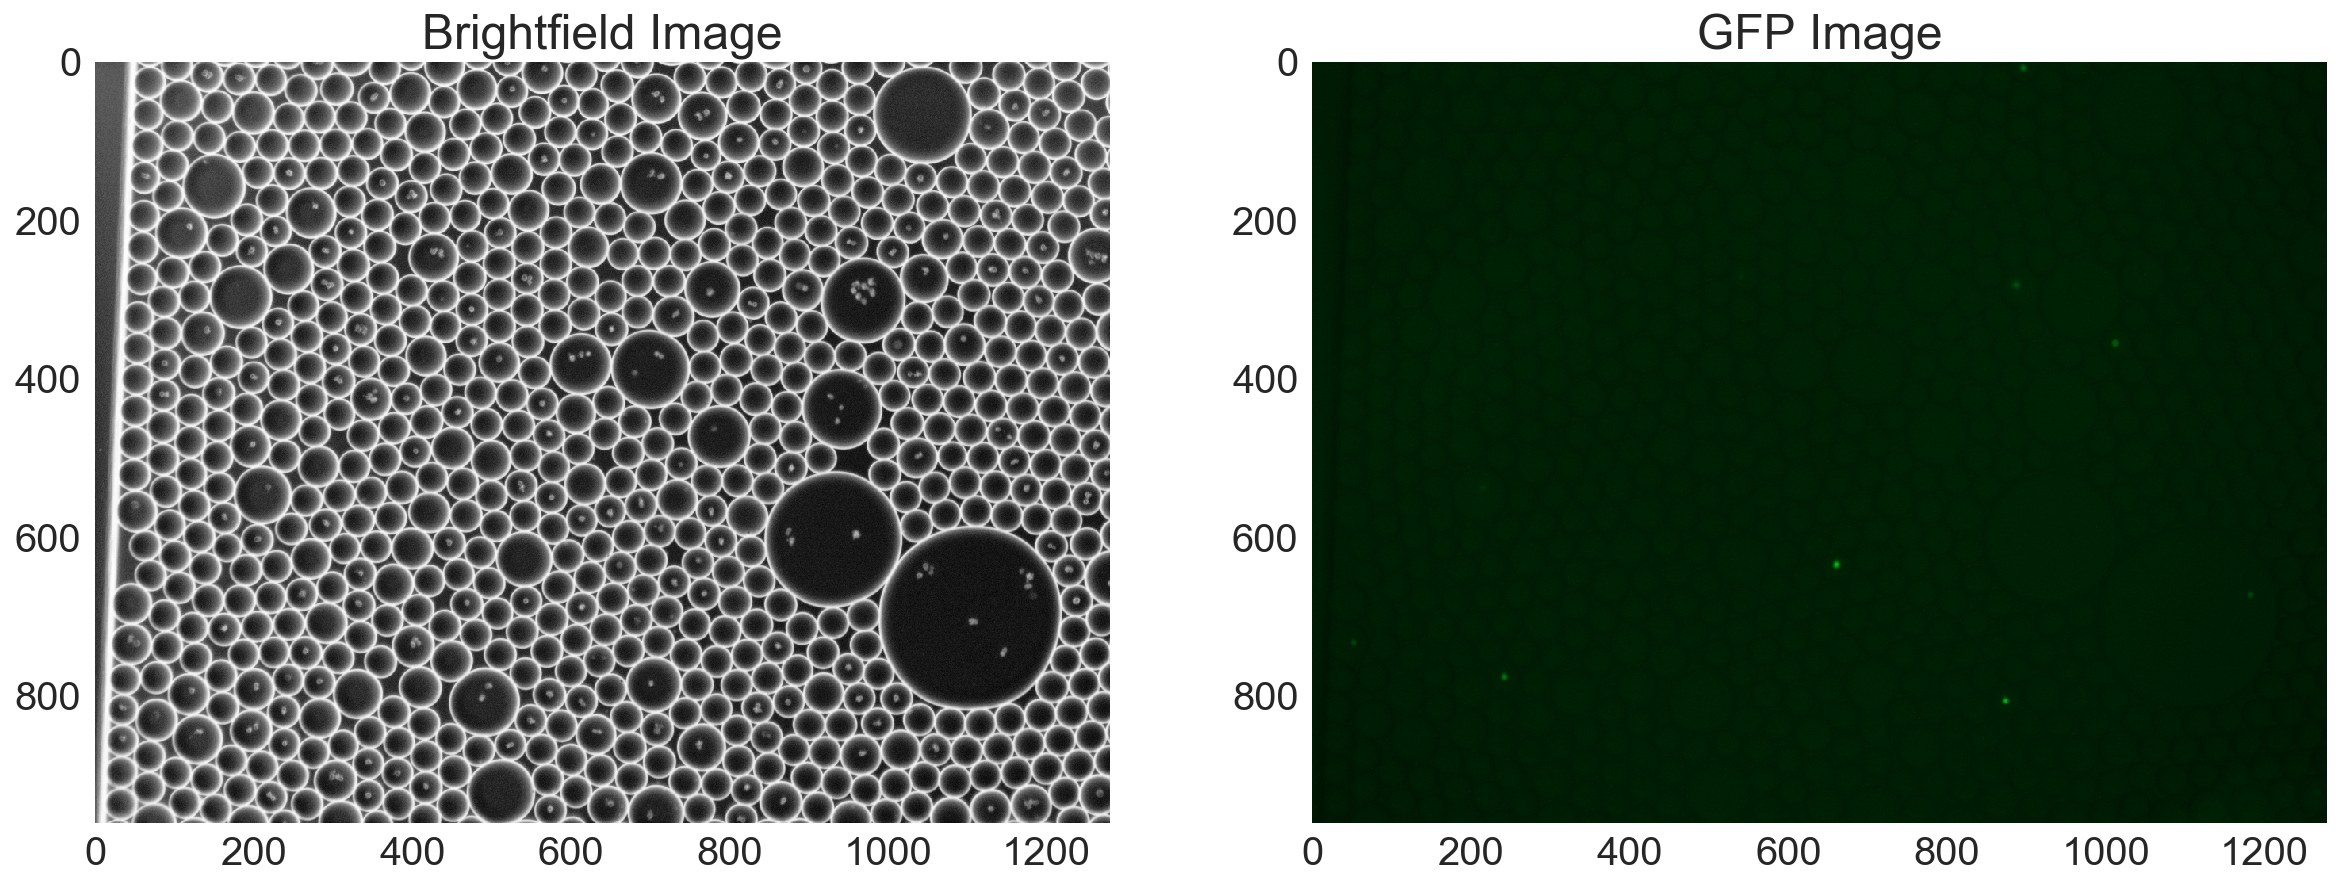

In [12]:
# Visualize the images
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(image_bright)
    ax[0].set_title('Brightfield Image')
    
    ax[1].imshow(image_gfp)
    ax[1].set_title('GFP Image')

In [15]:
# Threshold the brightfield image and determine the value of the outline

# Create histogram data from the brightfield image
hist_bright, bins_bright = skimage.exposure.histogram(image_bright)

# Find the Otsu threshold
bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)

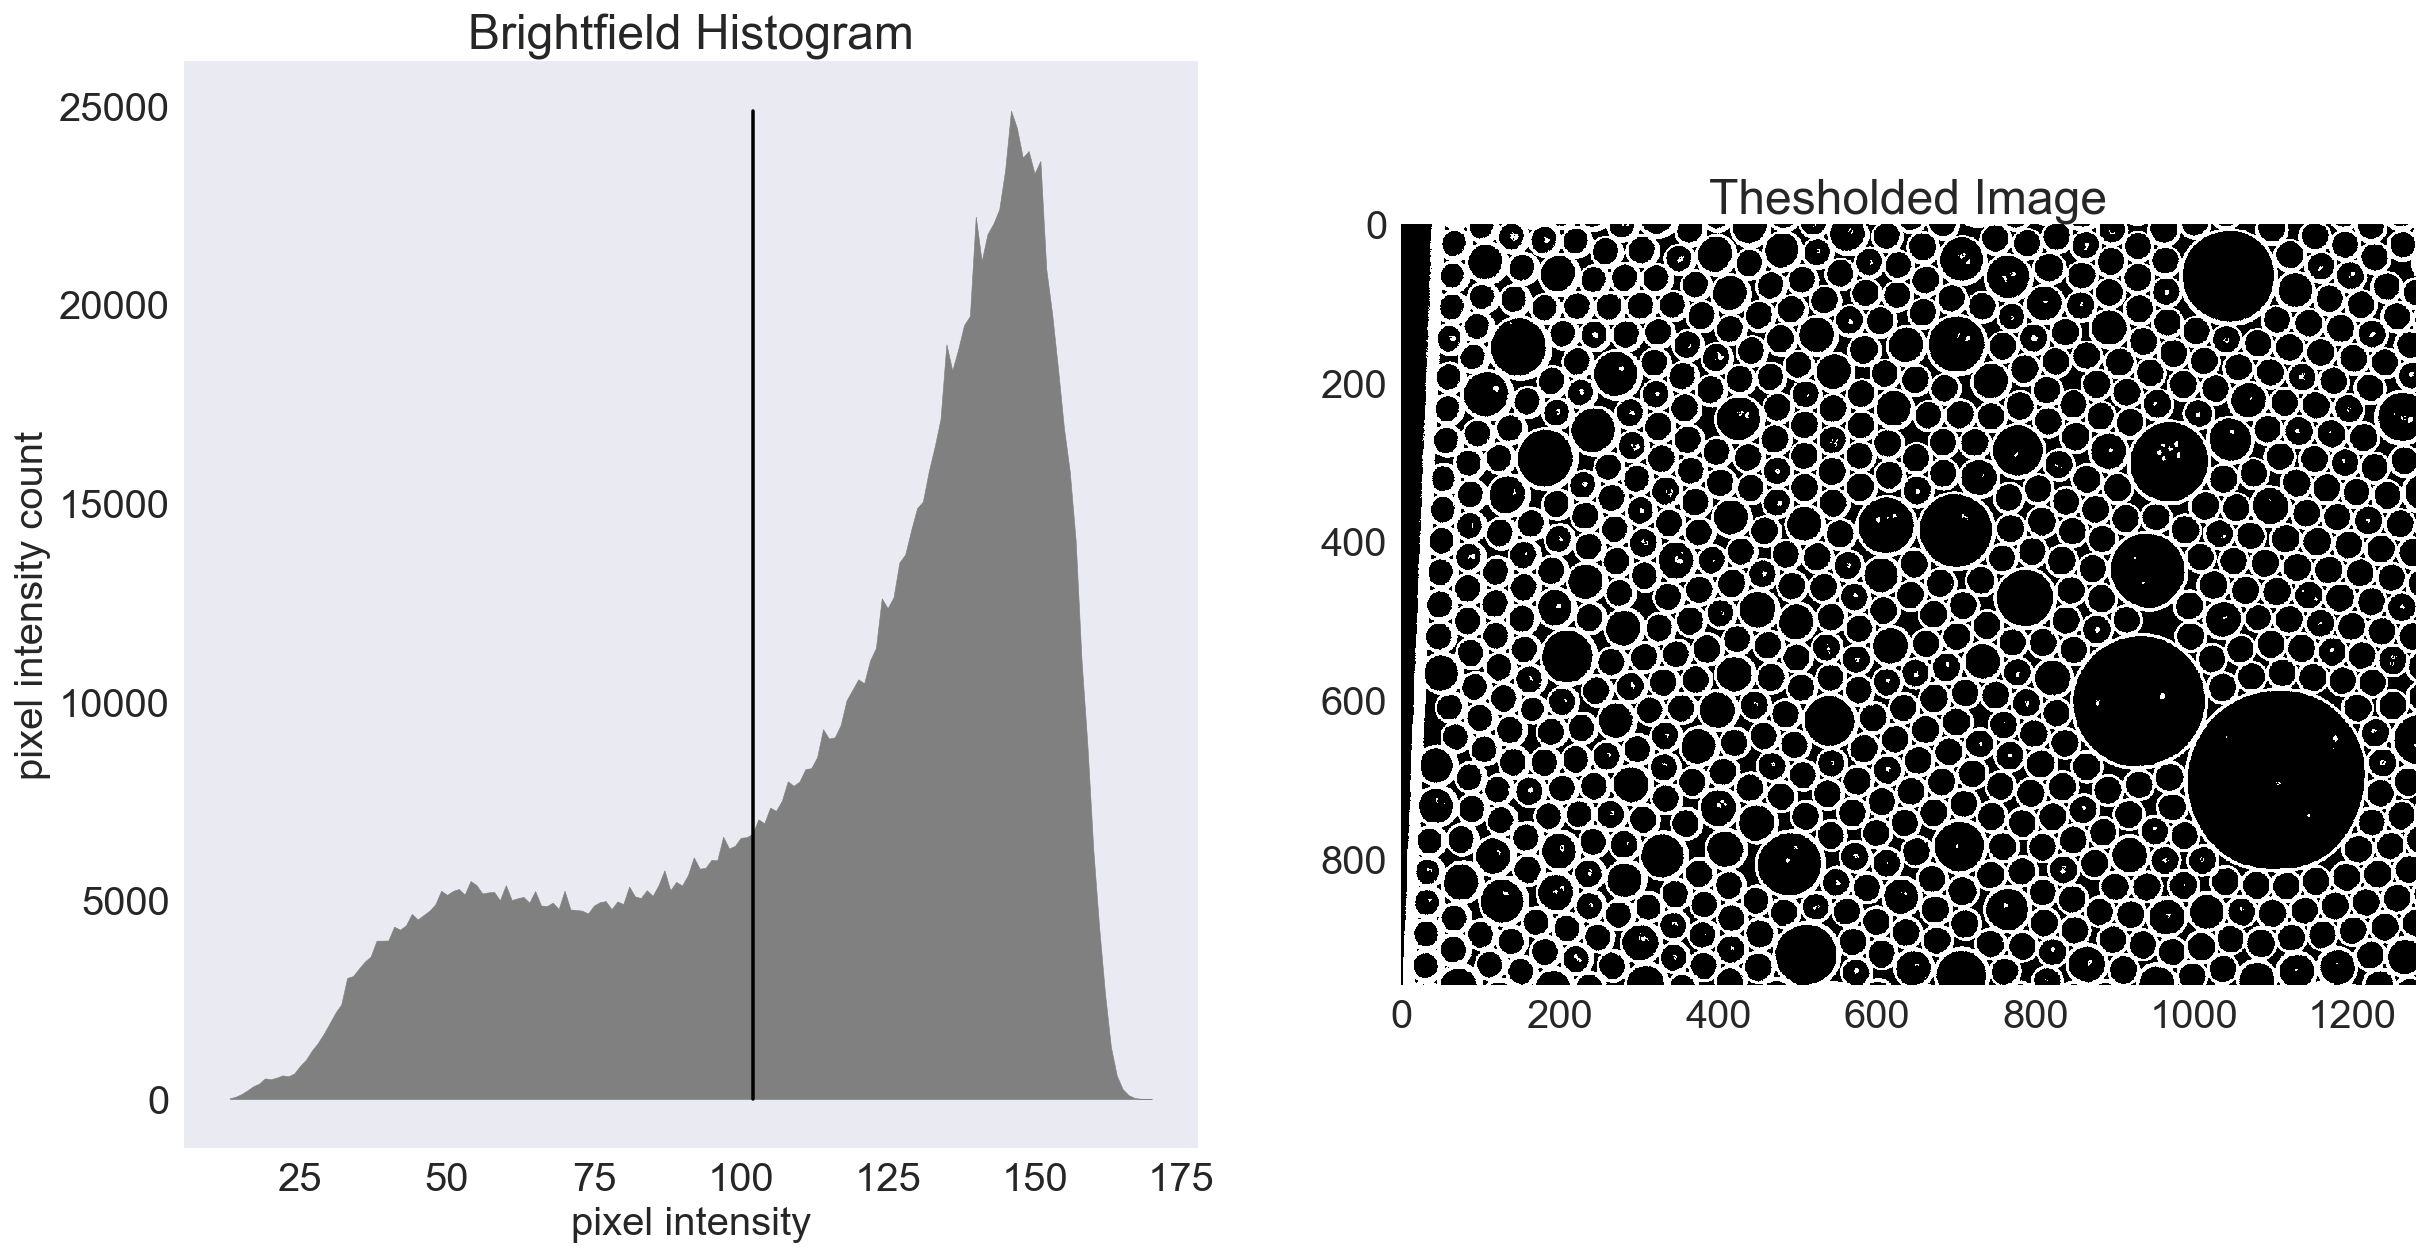

In [23]:
# Show both the histogram of the brightfield image and the thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].fill_between(bins_bright, hist_bright, color='Gray')
    ax[0].plot([bright_thresh_otsu, bright_thresh_otsu],[0, max(hist_bright)], color='black')
    ax[0].set_title('Brightfield Histogram')
    ax[0].set_xlabel('pixel intensity')
    ax[0].set_ylabel('pixel intensity count')
    
    ax[1].imshow(image_bright > bright_thresh_otsu)
    ax[1].set_title('Thesholded Image')

In [29]:
# Label thesholded images
bright_threshold = image_bright > bright_thresh_otsu
image_labeled, number_labels = skimage.measure.label(bright_threshold, background=0, return_num=True)

# Get the properties of the labeled regions
image_props = skimage.measure.regionprops(image_labeled)

808
2263
0.18759299747135066


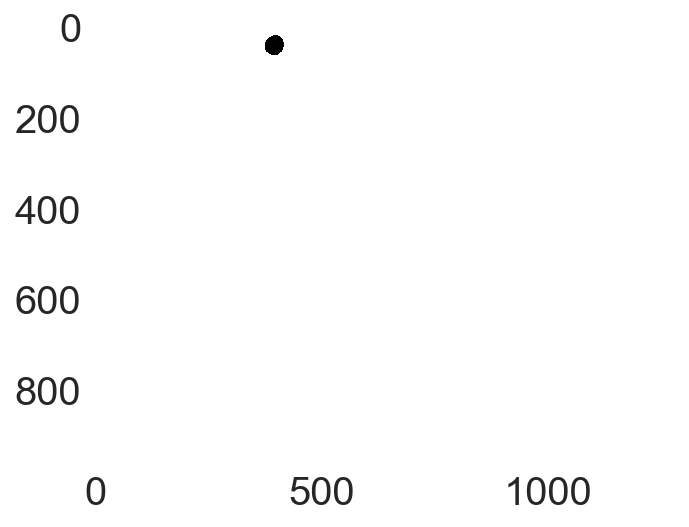

In [42]:
# Look at a sample region
with sns.axes_style('dark'):
    # Random number 
    rand_num = np.random.randint(number_labels)
    print(rand_num)
    
    temp_image = image_labeled==75
    plt.imshow(temp_image)
    print(image_props[75].area)
    print(image_props[75].eccentricity)
    

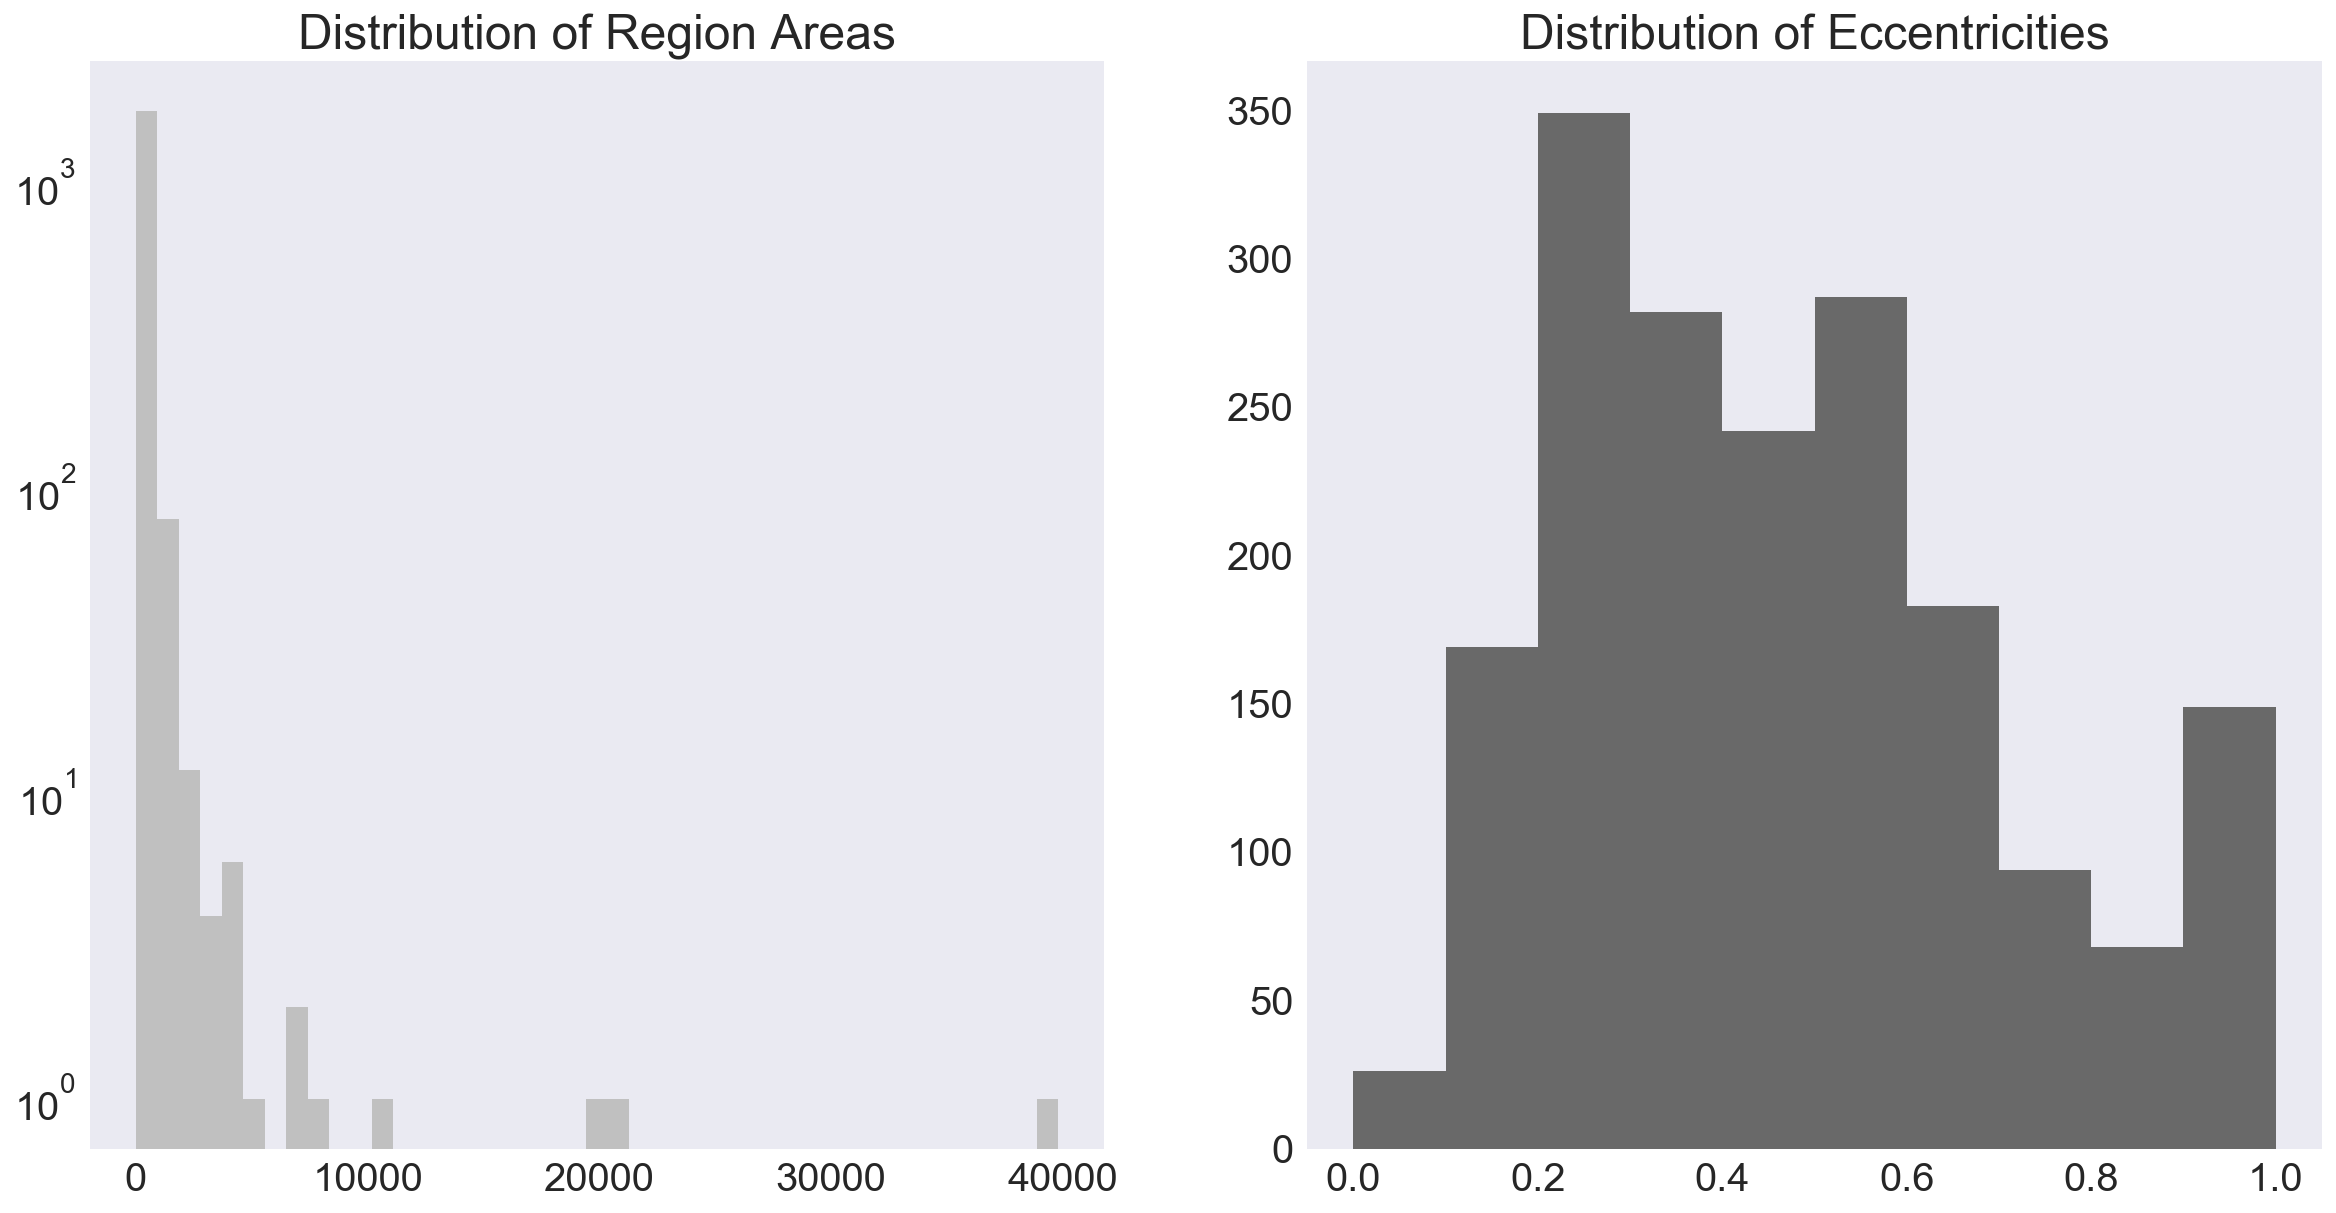

In [45]:
# Create a histogram of the region area and the eccentricity
droplet_area = [0]*number_labels
droplet_eccentricity = [0] * number_labels

for index, prop in enumerate(image_props):
    temp_area = prop.area
    temp_eccentricity = prop.eccentricity
    
    droplet_area[index] = temp_area
    droplet_eccentricity[index] = temp_eccentricity
    
# Show the two histograms
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].hist(droplet_area, bins=int(np.sqrt(len(droplet_area))), color='silver')
    ax[0].set_title("Distribution of Region Areas")
    ax[0].set_yscale('log')
    ax[1].hist(droplet_eccentricity, color= 'dimgray')
    ax[1].set_title("Distribution of Eccentricities")